In [59]:
%load_ext autoreload
import sys
sys.argv.append("-lc=C:/Workspaces/AIC/simod-master/local_config_files/fido-PC.cfg")
# sys.argv.append("-lc=C:/Workspaces/AIC/simod/local_config_files/fido-nb.cfg")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from simod.init import config
import roadmaptools.inout
import simod.statistics.model.edges as edges
import simod.statistics.comparisons.sensitivity_analysis as sa


In [61]:
peak_experiments = {
    'delay_experiments': [
        ["vga-max_delay_3_min", "vga"],
        ["vga-lim-max_delay_3_min", "vga-lim", "vga-lim-max_delay_5_min", "vga-lim-max_delay_6_min", "vga-lim-max_delay_7_min"],
        ["vga-pnas-max_delay_3_min", "vga-pnas", "vga-pnas-max_delay_5_min", "vga-pnas-max_delay_6_min", "vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["vga"],
        ["vga-lim", "vga-lim-batch_60s", "vga-lim-batch_90s", "vga-lim-batch_120s"],
        ["vga-pnas", "vga-pnas-batch_60s", "vga-pnas-batch_90s", "vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['vga-capacity_2', "vga"],
        ['vga-lim-capacity_2', "vga-lim", 'vga-lim-capacity_10'],
        ['vga-pnas-capacity_2', "vga-pnas", 'vga-pnas-capacity_10']
    ]
}

off_peak_experiments = {
    'delay_experiments': [
        ["sw-vga-max_delay_3_min", "sw-vga", "sw-vga-max_delay_5_min", "sw-vga-max_delay_6_min"],
        ["sw-vga-lim-max_delay_3_min", "sw-vga-lim", "sw-vga-lim-max_delay_5_min", "sw-vga-lim-max_delay_6_min", "sw-vga-lim-max_delay_7_min"],
        ["sw-vga-pnas-max_delay_3_min", "sw-vga-pnas", "sw-vga-pnas-max_delay_5_min", "sw-vga-pnas-max_delay_6_min", "sw-vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["sw-vga", "sw-vga-batch_60s", "sw-vga-batch_90s", "sw-vga-batch_120s"],
        ["sw-vga-lim", "sw-vga-lim-batch_60s", "sw-vga-lim-batch_90s", "sw-vga-lim-batch_120s"],
        ["sw-vga-pnas", "sw-vga-pnas-batch_60s", "sw-vga-pnas-batch_90s", "sw-vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['sw-vga-capacity_2', "sw-vga", 'sw-vga-capacity_10'],
        ['sw-vga-lim-capacity_2', "sw-vga-lim", 'sw-vga-lim-capacity_10'],
        ['sw-vga-pnas-capacity_2', "sw-vga-pnas", 'sw-vga-pnas-capacity_10']
    ]
}

manhattan_experiments = {
    'delay_experiments': [
        ["vga-max_delay_3_min", "vga_gap_0002-start_1830-real_speeds", "vga_gap_0002-start_1830-real_speeds-delay_5_min", "vga-max_delay_6_min"],
        ["vga-lim-max_delay_3_min", "vga-lim", "vga-lim-max_delay_5_min", "vga-lim-max_delay_6_min", "vga-lim-max_delay_7_min"],
        ["vga-pnas-unlimeted_vehicles-max_delay_3_min", "vga-pnas_unlimeted_vehicles-start_1830-real_speeds", "vga-pnas-unlimeted_vehicles-max_delay_5_min", "vga-pnas-unlimeted_vehicles-max_delay_6_min", "vga-pnas-unlimeted_vehicles-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["vga_gap_0002-start_1830-real_speeds", "vga-batch_60_s", "vga-batch_90_s", "vga-batch_120_s"],
        ["vga-lim", "vga-lim-batch_60_s", "vga-lim-batch_90_s", "vga-lim-batch_120_s"],
        ["vga-pnas_unlimeted_vehicles-start_1830-real_speeds", "vga-pnas-unlimeted_vehicles-batch_60_s", "vga-pnas-unlimeted_vehicles-batch_90_s", "vga-pnas-unlimeted_vehicles-batch_120_s"]
    ],
    'capacity_experiments':[
        ['vga-capacity_2', "vga_gap_0002-start_1830-real_speeds", 'vga-capacity_10'],
        ['vga-lim-capacity_2', "vga-lim", 'vga-lim-capacity_10'],
        ['vga-pnas-unlimeted_vehicles-capacity_2', "vga-pnas_unlimeted_vehicles-start_1830-real_speeds", 'vga-pnas-unlimeted_vehicles-capacity_10']
    ]
}
# for exp_set in manhattan_experiments.values():
#     for index, method in enumerate(exp_set):
#         new_list =  [f"Manhattan/{name}" for name in method]
#         exp_set[index] = new_list

In [62]:
loaded_edges = roadmaptools.inout.load_geojson(config.agentpolis.map_edges_filepath)
edge_data = edges.make_data_frame(loaded_edges)

[20:22:03]: Loading geojson file from: C:\AIC Experiment Data\VGA\maps\edges.geojson


In [63]:
x_values_delay = [3, 4, 5, 6, 7]
x_values_batch = [30, 60, 90, 120]
x_values_capacity = [2, 5, 10]

x_values = [x_values_batch, x_values_delay, x_values_capacity]

# Peak Experiments

In [64]:
sa.check_experiments(peak_experiments)
distance_data, comp_time_data, delay_data = sa.load_experiments(peak_experiments, edge_data)

[20:22:21]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-max_delay_3_min\ridesharing.csv to dataframe
[20:22:27]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga\ridesharing.csv to dataframe
[20:22:33]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_3_min\ridesharing.csv to dataframe
[20:22:38]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim\ridesharing.csv to dataframe
[20:22:43]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_5_min\ridesharing.csv to dataframe
[20:22:49]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_6_min\ridesharing.csv to dataframe
[20:22:55]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_7_min\ridesharing.csv to dataframe
[20:23:02]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-pnas-max_delay_3_min\ridesharing.csv to dataframe
[20:23:07]: Loading csv

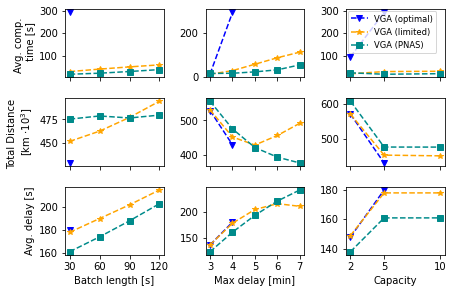

In [65]:
sa.plot_sensitivity_analysis(peak_experiments, distance_data, comp_time_data, delay_data, x_values)

# Off-peak Experiments

In [66]:
sa.check_experiments(off_peak_experiments)
offpeak_speed_data, offpeak_tt_data, offpeak_delay_data = sa.load_experiments(off_peak_experiments, edge_data)

[20:26:54]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_3_min\ridesharing.csv to dataframe
[20:26:57]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga\ridesharing.csv to dataframe
[20:26:58]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_5_min\ridesharing.csv to dataframe
[20:27:00]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_6_min\ridesharing.csv to dataframe
[20:27:03]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim-max_delay_3_min\ridesharing.csv to dataframe
[20:27:06]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim\ridesharing.csv to dataframe
[20:27:08]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim-max_delay_5_min\ridesharing.csv to dataframe
[20:27:10]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-lim-max_delay_6_min\ridesharing.csv to dataframe
[20:27:1

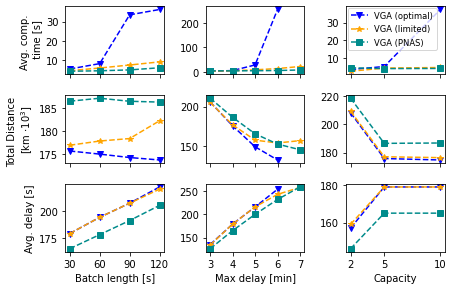

In [67]:
sa.plot_sensitivity_analysis(off_peak_experiments, offpeak_speed_data, offpeak_tt_data, offpeak_delay_data, x_values, "off_peak")

# Manhattan Experiments

In [68]:
loaded_edges_manhattan = roadmaptools.inout.load_geojson("C:\AIC Experiment Data\VGA Manhattan\maps/edges.geojson")
edge_data_manhattan = edges.make_data_frame(loaded_edges_manhattan)

[20:30:56]: Loading geojson file from: C:\AIC Experiment Data\VGA Manhattan\maps\edges.geojson


In [70]:
man_exp_dir = r"C:\AIC Experiment Data\VGA Manhattan\experiments/"
sa.check_experiments(manhattan_experiments, man_exp_dir)
manhattan_speed_data, manhattan_tt_data, manhattan_delay_data = sa.load_experiments(manhattan_experiments, edge_data_manhattan, man_exp_dir)

[20:29:04]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-max_delay_3_min\ridesharing.csv to dataframe
[20:29:05]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga_gap_0002-start_1830-real_speeds\ridesharing.csv to dataframe
[20:29:07]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga_gap_0002-start_1830-real_speeds-delay_5_min\ridesharing.csv to dataframe
[20:29:09]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-max_delay_6_min\ridesharing.csv to dataframe
[20:29:11]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-lim-max_delay_3_min\ridesharing.csv to dataframe
[20:29:13]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-lim\ridesharing.csv to dataframe
[20:29:14]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-lim-max_delay_5_min\ridesharing.csv to dataframe
[20:29:16]: Loading csv file 

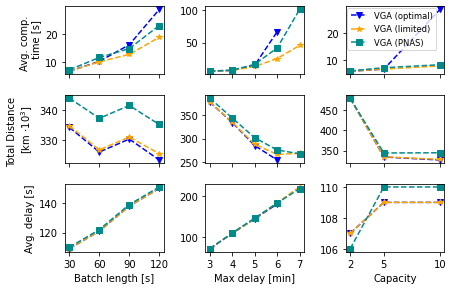

In [71]:
sa.plot_sensitivity_analysis(manhattan_experiments, manhattan_speed_data, manhattan_tt_data, manhattan_delay_data, x_values, "manhattan")

In [6]:
%autoreload
